In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline
#from imblearn.pipeline import make_pipeline as make_pipeline_imb
##from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import NearMiss
#from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, precision_recall_curve

In [2]:
train_data = pd.read_csv('training.csv', sep=',')
test_data = pd.read_csv('test.csv', sep=',')

In [6]:
pd.DataFrame({'Time' : train_data['TransactionStartTime']}).to_csv('train_trans_time.csv', index=False)
pd.DataFrame({'Time' : test_data['TransactionStartTime']}).to_csv('test_trans_time.csv', index=False)

In [4]:
train_data.drop([
    'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode',
    'CountryCode', 'ProductId'
], axis=1, inplace=True)

testTransId = test_data['TransactionId']
test_data.drop([
    'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode',
    'CountryCode', 'ProductId'], axis=1, inplace=True)

In [4]:
train_data.head(3)

,ProviderId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,ProviderId_6,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,ProviderId_4,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,ProviderId_6,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0


In [5]:
def amount_value(data):
    amount = data[0]
    value = data[1]
    
    if np.abs(amount) != value:
        return value - np.abs(amount)
    else:
        return 0
    
train_data['ExtraCharges'] = train_data[['Amount', 'Value']].apply(amount_value, axis=1)
test_data['ExtraCharges'] = test_data[['Amount', 'Value']].apply(amount_value, axis=1)

In [6]:
train_data.head(3)

,ProviderId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,ExtraCharges
0,ProviderId_6,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,0.0
1,ProviderId_4,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,0.0
2,ProviderId_6,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,0.0


In [7]:
newColumns = [
    'ProviderId', 'ProductCategory', 'ChannelId', 'Amount', 'ExtraCharges', 'Value',
    'TransactionStartTime', 'PricingStrategy', 'FraudResult'
]

train_data = train_data.reindex(columns=newColumns)
test_data = test_data.reindex(columns=newColumns[:-1])

In [8]:
train_data[['Value']].corrwith(train_data['Amount'])

Value    0.989692
dtype: float64

In [9]:
train_data.drop('Value', axis=1, inplace=True)
test_data.drop('Value', axis=1, inplace=True)

In [10]:
train_data.head(3)

,ProviderId,ProductCategory,ChannelId,Amount,ExtraCharges,TransactionStartTime,PricingStrategy,FraudResult
0,ProviderId_6,airtime,ChannelId_3,1000.0,0.0,2018-11-15T02:18:49Z,2,0
1,ProviderId_4,financial_services,ChannelId_2,-20.0,0.0,2018-11-15T02:19:08Z,2,0
2,ProviderId_6,airtime,ChannelId_3,500.0,0.0,2018-11-15T02:44:21Z,2,0


In [11]:
test_data.head(3)

,ProviderId,ProductCategory,ChannelId,Amount,ExtraCharges,TransactionStartTime,PricingStrategy
0,ProviderId_5,airtime,ChannelId_3,1000.0,0.0,2019-02-13T10:01:40Z,4
1,ProviderId_5,financial_services,ChannelId_3,2000.0,0.0,2019-02-13T10:02:12Z,2
2,ProviderId_4,financial_services,ChannelId_2,-50.0,0.0,2019-02-13T10:02:30Z,2


In [12]:
def get_year(trans_time):
    yr = trans_time.split('T')[0].split('-')[0]
    return yr

train_data['Year'] = train_data['TransactionStartTime'].map(get_year)
test_data['Year'] = test_data['TransactionStartTime'].map(get_year)

In [13]:
def get_month(trans_time):
    month = trans_time.split('T')[0].split('-')[1]
    
    if month == '11':
        return 'November'
    elif month == '12':
        return 'December'
    elif month == '01':
        return 'January'
    elif month == '02':
        return 'February'
    elif month == '03':
        return 'March'
    
train_data['Month'] = train_data['TransactionStartTime'].map(get_month)
test_data['Month'] = test_data['TransactionStartTime'].map(get_month)

In [14]:
from datetime import datetime
import calendar


def get_weekday(trans_time):
    yr = trans_time.split('T')[0].split('-')[0]
    month = trans_time.split('T')[0].split('-')[1]
    day = trans_time.split('T')[0].split('-')[2]
    
    date = datetime(year=int(yr), month=int(month), day=int(day))
    return calendar.day_name[date.weekday()]

train_data['Weekday'] = train_data['TransactionStartTime'].map(get_weekday)
test_data['Weekday'] = test_data['TransactionStartTime'].map(get_weekday)

In [15]:
train_data.head()

,ProviderId,ProductCategory,ChannelId,Amount,ExtraCharges,TransactionStartTime,PricingStrategy,FraudResult,Year,Month,Weekday
0,ProviderId_6,airtime,ChannelId_3,1000.0,0.0,2018-11-15T02:18:49Z,2,0,2018,November,Thursday
1,ProviderId_4,financial_services,ChannelId_2,-20.0,0.0,2018-11-15T02:19:08Z,2,0,2018,November,Thursday
2,ProviderId_6,airtime,ChannelId_3,500.0,0.0,2018-11-15T02:44:21Z,2,0,2018,November,Thursday
3,ProviderId_1,utility_bill,ChannelId_3,20000.0,1800.0,2018-11-15T03:32:55Z,2,0,2018,November,Thursday
4,ProviderId_4,financial_services,ChannelId_2,-644.0,0.0,2018-11-15T03:34:21Z,2,0,2018,November,Thursday


In [16]:
x='2018-11-15T02:18:49Z'

In [17]:
x.split('T')[1].split(':')[0]

'02'

In [18]:
def get_hour(trans_time):
    hour = trans_time.split('T')[1].split(':')[0]
    time_interval = ''
    
    if (hour=='00') | (hour=='01') | (hour=='02') | (hour=='03') | (hour=='04') | (hour=='05'):
        time_interval = 'early morning'
    elif (hour=='06') | (hour=='07') | (hour=='08') | (hour=='09') | (hour=='10') | (hour=='11'):
        time_interval = 'morning'
    elif (hour=='12') | (hour=='13') | (hour=='14') | (hour=='15'):
        time_interval = 'afternoon'
    elif (hour=='16') | (hour=='17') | (hour=='18') | (hour=='19'):
        time_interval = 'evening'
    elif (hour=='20') | (hour=='21') | (hour=='22') | (hour=='23'):
        time_interval = 'night'
        
    
    return time_interval


train_data['Time Interval'] = train_data['TransactionStartTime'].map(get_hour)
test_data['Time Interval'] = test_data['TransactionStartTime'].map(get_hour)

In [19]:
train_data['Time Interval'].value_counts()

morning          34342
evening          26061
afternoon        21950
early morning     7837
night             5472
Name: Time Interval, dtype: int64

In [20]:
test_data.head()

,ProviderId,ProductCategory,ChannelId,Amount,ExtraCharges,TransactionStartTime,PricingStrategy,Year,Month,Weekday,Time Interval
0,ProviderId_5,airtime,ChannelId_3,1000.0,0.0,2019-02-13T10:01:40Z,4,2019,February,Wednesday,morning
1,ProviderId_5,financial_services,ChannelId_3,2000.0,0.0,2019-02-13T10:02:12Z,2,2019,February,Wednesday,morning
2,ProviderId_4,financial_services,ChannelId_2,-50.0,0.0,2019-02-13T10:02:30Z,2,2019,February,Wednesday,morning
3,ProviderId_5,airtime,ChannelId_3,3000.0,0.0,2019-02-13T10:02:38Z,4,2019,February,Wednesday,morning
4,ProviderId_4,financial_services,ChannelId_2,-60.0,0.0,2019-02-13T10:02:58Z,2,2019,February,Wednesday,morning


In [21]:
train_data[['ExtraCharges']].corrwith(train_data['Amount'])

ExtraCharges    0.054714
dtype: float64

In [22]:
train_data.drop('TransactionStartTime', axis=1, inplace=True)
test_data.drop('TransactionStartTime', axis=1, inplace=True)

In [23]:
train_data.head(3)

,ProviderId,ProductCategory,ChannelId,Amount,ExtraCharges,PricingStrategy,FraudResult,Year,Month,Weekday,Time Interval
0,ProviderId_6,airtime,ChannelId_3,1000.0,0.0,2,0,2018,November,Thursday,early morning
1,ProviderId_4,financial_services,ChannelId_2,-20.0,0.0,2,0,2018,November,Thursday,early morning
2,ProviderId_6,airtime,ChannelId_3,500.0,0.0,2,0,2018,November,Thursday,early morning


In [24]:
fraudResult = train_data['FraudResult']

train_amount = train_data['Amount']
train_charges = train_data['ExtraCharges']

test_amount = test_data['Amount']
test_charges = test_data['ExtraCharges']


train_data = train_data.drop(['Amount', 'FraudResult', 'ExtraCharges'], axis=1)
test_data = test_data.drop(['Amount', 'ExtraCharges'], axis=1)

train_data['label'] = 1
test_data['label'] = 0

In [25]:
combined = pd.concat([train_data, test_data], axis=0)#.reset_index(drop=True)

In [26]:
combined.columns#[:-1]

Index(['ProviderId', 'ProductCategory', 'ChannelId', 'PricingStrategy', 'Year',
       'Month', 'Weekday', 'Time Interval', 'label'],
      dtype='object')

In [27]:
combined = pd.get_dummies(combined, columns=combined.columns[:-1], drop_first=True)

train_data = combined[combined['label']==1]
test_data = combined[combined['label']==0]

In [28]:
train_data.drop('label', axis=1, inplace=True)
test_data.drop('label', axis=1, inplace=True)

C:\Users\Immanuel\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
train_data = pd.concat([train_data, train_amount, train_charges, fraudResult], axis=1)
test_data = pd.concat([test_data, test_amount, test_charges,], axis=1)

In [30]:
train_data.head()

,ProviderId_ProviderId_2,ProviderId_ProviderId_3,ProviderId_ProviderId_4,ProviderId_ProviderId_5,ProviderId_ProviderId_6,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_retail,...,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Time Interval_early morning,Time Interval_evening,Time Interval_morning,Time Interval_night,Amount,ExtraCharges,FraudResult
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,1000.0,0.0,0
1,0,0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,-20.0,0.0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,500.0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,20000.0,1800.0,0
4,0,0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,-644.0,0.0,0


In [31]:
test_data.head()

,ProviderId_ProviderId_2,ProviderId_ProviderId_3,ProviderId_ProviderId_4,ProviderId_ProviderId_5,ProviderId_ProviderId_6,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_retail,...,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Time Interval_early morning,Time Interval_evening,Time Interval_morning,Time Interval_night,Amount,ExtraCharges
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1000.0,0.0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,2000.0,0.0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,-50.0,0.0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,3000.0,0.0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,-60.0,0.0


In [32]:
X, y = train_data.drop('FraudResult', axis=1), train_data['FraudResult']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

In [33]:
Counter(y_train)

Counter({0: 66828, 1: 135})

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
len(y_train[y_train==1])

135

In [36]:
cv = StratifiedKFold(n_splits=5, random_state=42)

XGBOOST

In [37]:
import xgboost as xgb
from xgboost import plot_importance

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
model = xgb.XGBClassifier(
    max_depth=4, min_child_weight=1, gamma = 0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
)

model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 0.708661
Test Score: 0.696203


C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [39]:
val = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=0).mean()


print('Model CV Score: {}'.format(val))

Model CV Score: 0.7125315288314457


In [40]:
params_1 = {
    'max_depth' : [3, 4, 5, 7],
    'min_child_weight' : list(range(1, 6, 2))
}

grid = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=4, min_child_weight=1, gamma = 0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_1, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid.fit(X_train, y_train)

grid.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.66168, std: 0.07514, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.65352, std: 0.08054, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.63776, std: 0.06330, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.71253, std: 0.06390, params: {'max_depth': 4, 'min_child_weight': 1},
 mean: 0.70713, std: 0.07367, params: {'max_depth': 4, 'min_child_weight': 3},
 mean: 0.69759, std: 0.07121, params: {'max_depth': 4, 'min_child_weight': 5},
 mean: 0.75590, std: 0.06362, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.72137, std: 0.07115, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.71542, std: 0.05914, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.77806, std: 0.07052, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.75103, std: 0.07047, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.73176, std: 0.06451, params: {'max_depth': 7, 'min_child_weight': 5}]

In [41]:
grid.best_params_, grid.best_score_

({'max_depth': 7, 'min_child_weight': 1}, 0.7780571360256477)

In [42]:
params_2 = {
    'max_depth' : [6, 7, 8],
    'min_child_weight' : [1, 2, 3]
}

grid2 = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=4, min_child_weight=1, gamma = 0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_2, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid2.fit(X_train, y_train)

grid2.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.77943, std: 0.06605, params: {'max_depth': 6, 'min_child_weight': 1},
 mean: 0.76378, std: 0.07073, params: {'max_depth': 6, 'min_child_weight': 2},
 mean: 0.74330, std: 0.07273, params: {'max_depth': 6, 'min_child_weight': 3},
 mean: 0.77806, std: 0.07052, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.77806, std: 0.07673, params: {'max_depth': 7, 'min_child_weight': 2},
 mean: 0.75103, std: 0.07047, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.78984, std: 0.06788, params: {'max_depth': 8, 'min_child_weight': 1},
 mean: 0.77737, std: 0.07337, params: {'max_depth': 8, 'min_child_weight': 2},
 mean: 0.75155, std: 0.07299, params: {'max_depth': 8, 'min_child_weight': 3}]

In [43]:
grid2.best_params_, grid2.best_score_

({'max_depth': 8, 'min_child_weight': 1}, 0.7898396911942334)

In [44]:
params_3 = {
    'max_depth' : [6, 7, 8, 9, 10, 11, 12],

}

grid3 = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=4, min_child_weight=1, gamma = 0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_3, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid3.fit(X_train, y_train)

grid3.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.77943, std: 0.06605, params: {'max_depth': 6},
 mean: 0.77806, std: 0.07052, params: {'max_depth': 7},
 mean: 0.78984, std: 0.06788, params: {'max_depth': 8},
 mean: 0.78932, std: 0.07050, params: {'max_depth': 9},
 mean: 0.78806, std: 0.06346, params: {'max_depth': 10},
 mean: 0.79130, std: 0.06923, params: {'max_depth': 11},
 mean: 0.78426, std: 0.06848, params: {'max_depth': 12}]

In [45]:
grid3.best_params_, grid3.best_score_

({'max_depth': 11}, 0.7912991431784155)

In [46]:
params_4 = {
    'gamma' : [i/10.0 for i in range(0, 5)],

}

grid4 = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=11, min_child_weight=1, gamma = 0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_4, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid4.fit(X_train, y_train)

grid4.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.79130, std: 0.06923, params: {'gamma': 0.0},
 mean: 0.78870, std: 0.06744, params: {'gamma': 0.1},
 mean: 0.78676, std: 0.06923, params: {'gamma': 0.2},
 mean: 0.78676, std: 0.06923, params: {'gamma': 0.3},
 mean: 0.78424, std: 0.06780, params: {'gamma': 0.4}]

In [47]:
grid4.best_params_, grid4.best_score_

({'gamma': 0.0}, 0.7912991431784155)

In [48]:
params_5 = {
    'gamma' : np.arange(0.0, 0.1, 0.02)

}

grid5 = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=11, min_child_weight=1, gamma = 0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_5, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid5.fit(X_train, y_train)

grid5.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.79130, std: 0.06923, params: {'gamma': 0.0},
 mean: 0.79130, std: 0.06923, params: {'gamma': 0.02},
 mean: 0.79130, std: 0.06923, params: {'gamma': 0.04},
 mean: 0.79130, std: 0.06923, params: {'gamma': 0.06},
 mean: 0.79130, std: 0.06923, params: {'gamma': 0.08}]

In [50]:
grid5.best_params_, grid5.best_score_

({'gamma': 0.0}, 0.7912991431784155)

In [51]:
params_6 = {
    'subsample' : [i/10.0 for i in range(6, 10)],
    'colsample_bytree' : [i/10.0 for i in range(6, 10)]

}

grid6 = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=11, min_child_weight=1, gamma = 0.0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_6, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid6.fit(X_train, y_train)

grid6.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.78791, std: 0.08812, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
 mean: 0.77699, std: 0.06446, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
 mean: 0.77136, std: 0.07077, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
 mean: 0.78054, std: 0.07270, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
 mean: 0.79768, std: 0.06915, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
 mean: 0.78284, std: 0.06197, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
 mean: 0.78180, std: 0.06674, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
 mean: 0.78025, std: 0.06331, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
 mean: 0.79129, std: 0.05968, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
 mean: 0.77231, std: 0.07747, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
 mean: 0.79130, std: 0.06923, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
 mean: 0.79406, std: 0.05582, params: {'colsample_bytree': 0.8, 'subsample': 0.9},
 mea

In [52]:
grid6.best_params_, grid6.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.6}, 0.797681072214377)

In [80]:
params_7 = {
    'subsample' : np.arange(0.500, 0.70, 0.05),
    'colsample_bytree' : np.arange(0.600, 0.8, 0.05)
}

grid7 = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=11, min_child_weight=1, gamma = 0.0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_7, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid7.fit(X_train, y_train)

grid7.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.76027, std: 0.07034, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
 mean: 0.76419, std: 0.06811, params: {'colsample_bytree': 0.6, 'subsample': 0.55},
 mean: 0.78791, std: 0.08812, params: {'colsample_bytree': 0.6, 'subsample': 0.6000000000000001},
 mean: 0.77987, std: 0.06852, params: {'colsample_bytree': 0.6, 'subsample': 0.6500000000000001},
 mean: 0.76719, std: 0.07029, params: {'colsample_bytree': 0.65, 'subsample': 0.5},
 mean: 0.76572, std: 0.06458, params: {'colsample_bytree': 0.65, 'subsample': 0.55},
 mean: 0.79447, std: 0.07714, params: {'colsample_bytree': 0.65, 'subsample': 0.6000000000000001},
 mean: 0.78076, std: 0.07253, params: {'colsample_bytree': 0.65, 'subsample': 0.6500000000000001},
 mean: 0.78433, std: 0.07913, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.5},
 mean: 0.78338, std: 0.05245, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.55},
 mean: 0.79768, std: 0.06915, params: {'colsample_bytree': 0.700000000000

In [81]:
grid7.best_params_, grid7.best_score_

({'colsample_bytree': 0.7000000000000001, 'subsample': 0.6000000000000001},
 0.797681072214377)

In [85]:
params_8 = {
    
    'subsample' : [0.61, 0.62, 0.63, 0.64],
    'colsample_bytree' : [0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69]

}

grid8 = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=11, min_child_weight=1, gamma = 0.0, subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_8, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid8.fit(X_train, y_train)

grid8.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.79655, std: 0.07445, params: {'colsample_bytree': 0.63, 'subsample': 0.61},
 mean: 0.78556, std: 0.06269, params: {'colsample_bytree': 0.63, 'subsample': 0.62},
 mean: 0.78000, std: 0.06866, params: {'colsample_bytree': 0.63, 'subsample': 0.63},
 mean: 0.78076, std: 0.07253, params: {'colsample_bytree': 0.63, 'subsample': 0.64},
 mean: 0.79584, std: 0.07154, params: {'colsample_bytree': 0.64, 'subsample': 0.61},
 mean: 0.77804, std: 0.06068, params: {'colsample_bytree': 0.64, 'subsample': 0.62},
 mean: 0.78537, std: 0.06428, params: {'colsample_bytree': 0.64, 'subsample': 0.63},
 mean: 0.77756, std: 0.06759, params: {'colsample_bytree': 0.64, 'subsample': 0.64},
 mean: 0.79584, std: 0.07154, params: {'colsample_bytree': 0.65, 'subsample': 0.61},
 mean: 0.77804, std: 0.06068, params: {'colsample_bytree': 0.65, 'subsample': 0.62},
 mean: 0.78537, std: 0.06428, params: {'colsample_bytree': 0.65, 'subsample': 0.63},
 mean: 0.77756, std: 0.06759, params: {'colsample_bytree': 0.65, 

In [86]:
grid8.best_params_, grid8.best_score_

({'colsample_bytree': 0.66, 'subsample': 0.61}, 0.8118274551058706)

In [87]:
params_9 = {
    
    'reg_lambda' : [0.01, 0.05, 0.1, 0.5, 1],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]

}

grid9 = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=11, min_child_weight=1, gamma = 0.0, subsample=0.61, colsample_bytree=0.66,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_9, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid9.fit(X_train, y_train)

grid9.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.80166, std: 0.08557, params: {'reg_alpha': 0, 'reg_lambda': 0.01},
 mean: 0.80615, std: 0.08297, params: {'reg_alpha': 0, 'reg_lambda': 0.05},
 mean: 0.80564, std: 0.08122, params: {'reg_alpha': 0, 'reg_lambda': 0.1},
 mean: 0.80301, std: 0.07987, params: {'reg_alpha': 0, 'reg_lambda': 0.5},
 mean: 0.81183, std: 0.06926, params: {'reg_alpha': 0, 'reg_lambda': 1},
 mean: 0.80166, std: 0.08557, params: {'reg_alpha': 0.001, 'reg_lambda': 0.01},
 mean: 0.80615, std: 0.08297, params: {'reg_alpha': 0.001, 'reg_lambda': 0.05},
 mean: 0.80564, std: 0.08122, params: {'reg_alpha': 0.001, 'reg_lambda': 0.1},
 mean: 0.80301, std: 0.07987, params: {'reg_alpha': 0.001, 'reg_lambda': 0.5},
 mean: 0.81183, std: 0.06926, params: {'reg_alpha': 0.001, 'reg_lambda': 1},
 mean: 0.80564, std: 0.08122, params: {'reg_alpha': 0.005, 'reg_lambda': 0.01},
 mean: 0.80166, std: 0.08557, params: {'reg_alpha': 0.005, 'reg_lambda': 0.05},
 mean: 0.80814, std: 0.08120, params: {'reg_alpha': 0.005, 'reg_lambda

In [88]:
grid9.best_params_, grid9.best_score_

({'reg_alpha': 0, 'reg_lambda': 1}, 0.8118274551058706)

In [91]:
params_10 = {
    
    'reg_lambda' : [0.6, 0.7, 0.8, 0.9, 1, 1.1],
    'reg_alpha':[0.0001, 0.0002, 0.00035, 0.00045]

}

grid10 = GridSearchCV(
    xgb.XGBClassifier(
    max_depth=11, min_child_weight=1, gamma = 0.0, subsample=0.61, colsample_bytree=0.66,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1
), params_10, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

grid10.fit(X_train, y_train)

grid10.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.80102, std: 0.08259, params: {'reg_alpha': 0.0001, 'reg_lambda': 0.6},
 mean: 0.80888, std: 0.06566, params: {'reg_alpha': 0.0001, 'reg_lambda': 0.7},
 mean: 0.81183, std: 0.06926, params: {'reg_alpha': 0.0001, 'reg_lambda': 0.8},
 mean: 0.81183, std: 0.06926, params: {'reg_alpha': 0.0001, 'reg_lambda': 0.9},
 mean: 0.81183, std: 0.06926, params: {'reg_alpha': 0.0001, 'reg_lambda': 1},
 mean: 0.79065, std: 0.05345, params: {'reg_alpha': 0.0001, 'reg_lambda': 1.1},
 mean: 0.80102, std: 0.08259, params: {'reg_alpha': 0.0002, 'reg_lambda': 0.6},
 mean: 0.80888, std: 0.06566, params: {'reg_alpha': 0.0002, 'reg_lambda': 0.7},
 mean: 0.81183, std: 0.06926, params: {'reg_alpha': 0.0002, 'reg_lambda': 0.8},
 mean: 0.81183, std: 0.06926, params: {'reg_alpha': 0.0002, 'reg_lambda': 0.9},
 mean: 0.81183, std: 0.06926, params: {'reg_alpha': 0.0002, 'reg_lambda': 1},
 mean: 0.79065, std: 0.05345, params: {'reg_alpha': 0.0002, 'reg_lambda': 1.1},
 mean: 0.80102, std: 0.08259, params: {'reg_

In [90]:
grid10.best_params_, grid10.best_score_

({'reg_alpha': 0.0002, 'reg_lambda': 1}, 0.8118274551058706)

In [38]:
xgbc = xgb.XGBClassifier(n_estimators=16000, learning_rate=0.007,
    max_depth=11, min_child_weight=1, gamma = 0.0, subsample=0.61, colsample_bytree=0.66,
    scale_pos_weight = len(y_train[y_train]==0)/len(y_train[y_train==1]), nthread=-1,
    reg_alpha=0.0002, reg_lambda=1
)

In [93]:



xgbc.fit(X_train, y_train)


train_predictions = xgbc.predict(X_train)
test_predictions = xgbc.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train Score: 0.846395
Test Score: 0.773723


C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [94]:
cross_val_score(xgbc, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=0).mean()

0.7804617676048415

In [39]:
from sklearn.metrics import f1_score

In [ ]:
#cv = StratifiedKFold(n_splits=10, random_state=42)
def plot_learning_curves(model, X, y):    
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)    
    train_errors, val_errors = [], []    
    for train, test in cv.split(X_train.values, y_train.values):        
        model.fit(X_train.values[train], y_train.values[train])        
        y_train_predict = model.predict(X_train.values[train])

        y_val_predict = model.predict(X_train.values[test])        
        train_errors.append(1 - f1_score(y_train.values[train], y_train_predict))        
        val_errors.append(1 - f1_score(y_train.values[test], y_val_predict))    
    plt.plot(train_errors, "r-+", linewidth=2, label="train")    
    plt.plot(val_errors, "b-", linewidth=3, label="val")
    plt.legend()
    
    

        

                
                 
plot_learning_curves(classifier, X_train, y_train
)

LIGHTGBM

In [40]:
import lightgbm as lgb

In [40]:
Counter(y_train)

Counter({0: 66828, 1: 135})

In [48]:
model = lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=31, max_depth=5, 
    min_child_samples=20, min_child_weight=0.001, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
)

model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train Score: 0.752089
Test Score: 0.675000


C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [49]:
cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=0).mean()

0.7336842517800837

In [42]:
lgb_params_1 = {
    'num_leaves' : [10, 15, 20, 25, 30, 35],
    'max_depth' : list(range(1, 6, 2)),
}

lgb_grid = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=31, max_depth=5, 
    min_child_samples=20, min_child_weight=0.001, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
), lgb_params_1, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid.fit(X_train, y_train)

lgb_grid.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.51924, std: 0.01553, params: {'max_depth': 1, 'min_child_samples': 15},
 mean: 0.52361, std: 0.01634, params: {'max_depth': 1, 'min_child_samples': 20},
 mean: 0.52361, std: 0.01634, params: {'max_depth': 1, 'min_child_samples': 25},
 mean: 0.52361, std: 0.01634, params: {'max_depth': 1, 'min_child_samples': 30},
 mean: 0.68645, std: 0.06415, params: {'max_depth': 3, 'min_child_samples': 15},
 mean: 0.69242, std: 0.06693, params: {'max_depth': 3, 'min_child_samples': 20},
 mean: 0.68676, std: 0.06756, params: {'max_depth': 3, 'min_child_samples': 25},
 mean: 0.68007, std: 0.06889, params: {'max_depth': 3, 'min_child_samples': 30},
 mean: 0.74657, std: 0.06064, params: {'max_depth': 5, 'min_child_samples': 15},
 mean: 0.73368, std: 0.05783, params: {'max_depth': 5, 'min_child_samples': 20},
 mean: 0.72153, std: 0.06230, params: {'max_depth': 5, 'min_child_samples': 25},
 mean: 0.72602, std: 0.07105, params: {'max_depth': 5, 'min_child_samples': 30}]

In [43]:
lgb_grid.best_params_, lgb_grid.best_score_

({'max_depth': 5, 'min_child_samples': 15}, 0.7465692790896421)

In [ ]:
lgb_params_2 = {
    'min_child_samples' : [5, 10, 15, 19],
    'max_depth' : [4, 5, 6, 7, 8, 9]
}

lgb_grid2 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=31, max_depth=5, 
    min_child_samples=20, min_child_weight=0.001, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
), lgb_params_2, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid2.fit(X_train, y_train)

lgb_grid2.grid_scores_

In [53]:
lgb_grid2.best_params_, lgb_grid2.best_score_

({'max_depth': 7, 'num_leaves': 21}, 0.748264370662598)

In [54]:
lgb_params_3 = {
    'min_child_samples' : [15, 20, 25, 30],
    'min_child_weight' : [0.001, 0.01, 0.1, 1],
    'min_split_gain' : [0.0, 0.2, 0.4, 0.6]
}

lgb_grid3 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=20, min_child_weight=0.001, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
), lgb_params_3, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid3.fit(X_train, y_train)

lgb_grid3.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.73220, std: 0.05618, params: {'min_child_samples': 15, 'min_child_weight': 0.001, 'min_split_gain': 0.0},
 mean: 0.75205, std: 0.06141, params: {'min_child_samples': 15, 'min_child_weight': 0.001, 'min_split_gain': 0.2},
 mean: 0.74539, std: 0.06200, params: {'min_child_samples': 15, 'min_child_weight': 0.001, 'min_split_gain': 0.4},
 mean: 0.73293, std: 0.05865, params: {'min_child_samples': 15, 'min_child_weight': 0.001, 'min_split_gain': 0.6},
 mean: 0.73220, std: 0.05618, params: {'min_child_samples': 15, 'min_child_weight': 0.01, 'min_split_gain': 0.0},
 mean: 0.75205, std: 0.06141, params: {'min_child_samples': 15, 'min_child_weight': 0.01, 'min_split_gain': 0.2},
 mean: 0.74539, std: 0.06200, params: {'min_child_samples': 15, 'min_child_weight': 0.01, 'min_split_gain': 0.4},
 mean: 0.73651, std: 0.05670, params: {'min_child_samples': 15, 'min_child_weight': 0.01, 'min_split_gain': 0.6},
 mean: 0.74747, std: 0.06272, params: {'min_child_samples': 15, 'min_child_weight': 

In [55]:
lgb_grid3.best_params_, lgb_grid3.best_score_

({'min_child_samples': 15, 'min_child_weight': 0.1, 'min_split_gain': 0.2},
 0.760378471569263)

In [41]:
lgb_params_4 = {
    'min_child_samples' : list(range(10, 20, 2)),
    'min_child_weight' : [0.03, 0.05, 0.1, 0.15],
    'min_split_gain' : [0.0, 0.2, 0.4, 0.6]
                               
                               }

lgb_grid4 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=20, min_child_weight=0.001, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
), lgb_params_4, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid4.fit(X_train, y_train)

lgb_grid4.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.75230, std: 0.06857, params: {'min_child_samples': 10, 'min_child_weight': 0.03, 'min_split_gain': 0.0},
 mean: 0.75884, std: 0.05437, params: {'min_child_samples': 10, 'min_child_weight': 0.03, 'min_split_gain': 0.05},
 mean: 0.76301, std: 0.05541, params: {'min_child_samples': 10, 'min_child_weight': 0.03, 'min_split_gain': 0.1},
 mean: 0.75429, std: 0.07395, params: {'min_child_samples': 10, 'min_child_weight': 0.03, 'min_split_gain': 0.15000000000000002},
 mean: 0.76267, std: 0.05837, params: {'min_child_samples': 10, 'min_child_weight': 0.03, 'min_split_gain': 0.2},
 mean: 0.75514, std: 0.05432, params: {'min_child_samples': 10, 'min_child_weight': 0.03, 'min_split_gain': 0.25},
 mean: 0.75887, std: 0.05271, params: {'min_child_samples': 10, 'min_child_weight': 0.03, 'min_split_gain': 0.30000000000000004},
 mean: 0.74105, std: 0.07017, params: {'min_child_samples': 10, 'min_child_weight': 0.03, 'min_split_gain': 0.35000000000000003},
 mean: 0.74813, std: 0.06439, params: 

In [42]:
lgb_grid4.best_params_, lgb_grid4.best_score_

({'min_child_samples': 12,
  'min_child_weight': 0.15,
  'min_split_gain': 0.15000000000000002},
 0.7697224790315436)

In [44]:
lgb_params_5 = {
    'min_child_samples' : [11, 12, 13],
    'min_child_weight' : [0.15, 0.30, 0.45, 0.50],
    'min_split_gain' : [0.1, 0.13, 0.16, 0.19, 0.2]
                               
                               }

lgb_grid5 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=20, min_child_weight=0.001, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
), lgb_params_5, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid5.fit(X_train, y_train)

lgb_grid5.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.77053, std: 0.06150, params: {'min_child_samples': 11, 'min_child_weight': 0.15, 'min_split_gain': 0.1},
 mean: 0.75585, std: 0.06537, params: {'min_child_samples': 11, 'min_child_weight': 0.15, 'min_split_gain': 0.13},
 mean: 0.76442, std: 0.05512, params: {'min_child_samples': 11, 'min_child_weight': 0.15, 'min_split_gain': 0.16},
 mean: 0.75374, std: 0.06960, params: {'min_child_samples': 11, 'min_child_weight': 0.15, 'min_split_gain': 0.19},
 mean: 0.76283, std: 0.05701, params: {'min_child_samples': 11, 'min_child_weight': 0.15, 'min_split_gain': 0.2},
 mean: 0.75072, std: 0.08050, params: {'min_child_samples': 11, 'min_child_weight': 0.3, 'min_split_gain': 0.1},
 mean: 0.75428, std: 0.07787, params: {'min_child_samples': 11, 'min_child_weight': 0.3, 'min_split_gain': 0.13},
 mean: 0.75428, std: 0.07787, params: {'min_child_samples': 11, 'min_child_weight': 0.3, 'min_split_gain': 0.16},
 mean: 0.76620, std: 0.05423, params: {'min_child_samples': 11, 'min_child_weight': 0.

In [45]:
lgb_grid5.best_params_, lgb_grid5.best_score_

({'min_child_samples': 13, 'min_child_weight': 0.3, 'min_split_gain': 0.16},
 0.774761430125497)

In [46]:
lgb_params_7 = {
    
    'min_child_weight' : [0.2, 0.25, 0.30, 0.35, 0.4],
    'min_split_gain' : [0.14, 0.15, 0.16, 0.17, 0.18, 0.19]
                               
                               }

lgb_grid7 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.001, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
), lgb_params_7, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid7.fit(X_train, y_train)

lgb_grid7.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.76509, std: 0.06202, params: {'min_child_weight': 0.2, 'min_split_gain': 0.14},
 mean: 0.76692, std: 0.05970, params: {'min_child_weight': 0.2, 'min_split_gain': 0.15},
 mean: 0.76591, std: 0.05456, params: {'min_child_weight': 0.2, 'min_split_gain': 0.16},
 mean: 0.76509, std: 0.06202, params: {'min_child_weight': 0.2, 'min_split_gain': 0.17},
 mean: 0.76509, std: 0.06202, params: {'min_child_weight': 0.2, 'min_split_gain': 0.18},
 mean: 0.76879, std: 0.05747, params: {'min_child_weight': 0.2, 'min_split_gain': 0.19},
 mean: 0.76180, std: 0.05370, params: {'min_child_weight': 0.25, 'min_split_gain': 0.14},
 mean: 0.76250, std: 0.05886, params: {'min_child_weight': 0.25, 'min_split_gain': 0.15},
 mean: 0.76692, std: 0.05970, params: {'min_child_weight': 0.25, 'min_split_gain': 0.16},
 mean: 0.76122, std: 0.06149, params: {'min_child_weight': 0.25, 'min_split_gain': 0.17},
 mean: 0.76692, std: 0.05970, params: {'min_child_weight': 0.25, 'min_split_gain': 0.18},
 mean: 0.76238, 

In [47]:
lgb_grid7.best_params_, lgb_grid7.best_score_

({'min_child_weight': 0.3, 'min_split_gain': 0.16}, 0.774761430125497)

In [48]:
lgb_params_8 = {
    
    'subsample' : [0.5, 0.6, 0.7, 0.8],
    'colsample_bytree' : [0.5, 0.6, 0.7, 0.8]
                               
                               }

lgb_grid8 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
), lgb_params_8, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid8.fit(X_train, y_train)

lgb_grid8.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.77331, std: 0.02887, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
 mean: 0.72474, std: 0.03699, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
 mean: 0.72107, std: 0.05189, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
 mean: 0.74077, std: 0.05412, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
 mean: 0.79387, std: 0.03105, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
 mean: 0.73424, std: 0.05172, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
 mean: 0.74649, std: 0.04438, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
 mean: 0.75208, std: 0.05456, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
 mean: 0.79166, std: 0.01373, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
 mean: 0.74487, std: 0.07113, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
 mean: 0.75982, std: 0.06030, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
 mean: 0.76659, std: 0.05817, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
 mea

In [49]:
lgb_grid8.best_params_, lgb_grid8.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.5}, 0.8032066226101563)

In [50]:
lgb_params_9 = {
    
    'subsample' : np.arange(0.3, 0.6, 0.05),
    'colsample_bytree' : np.arange(0.705, 0.9, 0.05)
                               
                               }

lgb_grid9 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
), lgb_params_9, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid9.fit(X_train, y_train)

lgb_grid9.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.78876, std: 0.01973, params: {'colsample_bytree': 0.705, 'subsample': 0.3},
 mean: 0.80252, std: 0.02076, params: {'colsample_bytree': 0.705, 'subsample': 0.35},
 mean: 0.78621, std: 0.02230, params: {'colsample_bytree': 0.705, 'subsample': 0.39999999999999997},
 mean: 0.79961, std: 0.01814, params: {'colsample_bytree': 0.705, 'subsample': 0.44999999999999996},
 mean: 0.79166, std: 0.01373, params: {'colsample_bytree': 0.705, 'subsample': 0.49999999999999994},
 mean: 0.74370, std: 0.05980, params: {'colsample_bytree': 0.705, 'subsample': 0.5499999999999999},
 mean: 0.78547, std: 0.02215, params: {'colsample_bytree': 0.755, 'subsample': 0.3},
 mean: 0.79184, std: 0.01875, params: {'colsample_bytree': 0.755, 'subsample': 0.35},
 mean: 0.77711, std: 0.01497, params: {'colsample_bytree': 0.755, 'subsample': 0.39999999999999997},
 mean: 0.79932, std: 0.01323, params: {'colsample_bytree': 0.755, 'subsample': 0.44999999999999996},
 mean: 0.79769, std: 0.00627, params: {'colsample_byt

In [51]:
lgb_grid9.best_params_, lgb_grid9.best_score_

({'colsample_bytree': 0.8550000000000001, 'subsample': 0.49999999999999994},
 0.8046487295877308)

In [54]:
lgb_params_10 = {
    
    'subsample' : [0.47, 0.475, 0.48, 0.485, 0.49, 0.495, 0.50],
    'colsample_bytree' : [0.81, 0.815, 0.82, 0.825, 0.83]
                               
                               }

lgb_grid10 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.8, 
    colsample_bytree=0.8, subsample_freq=5
), lgb_params_10, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid10.fit(X_train, y_train)

lgb_grid10.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.79177, std: 0.01110, params: {'colsample_bytree': 0.81, 'subsample': 0.47},
 mean: 0.80277, std: 0.00860, params: {'colsample_bytree': 0.81, 'subsample': 0.475},
 mean: 0.79927, std: 0.01436, params: {'colsample_bytree': 0.81, 'subsample': 0.48},
 mean: 0.80844, std: 0.02153, params: {'colsample_bytree': 0.81, 'subsample': 0.485},
 mean: 0.80044, std: 0.01642, params: {'colsample_bytree': 0.81, 'subsample': 0.49},
 mean: 0.79939, std: 0.01700, params: {'colsample_bytree': 0.81, 'subsample': 0.495},
 mean: 0.80321, std: 0.01366, params: {'colsample_bytree': 0.81, 'subsample': 0.5},
 mean: 0.79177, std: 0.01110, params: {'colsample_bytree': 0.815, 'subsample': 0.47},
 mean: 0.80277, std: 0.00860, params: {'colsample_bytree': 0.815, 'subsample': 0.475},
 mean: 0.79927, std: 0.01436, params: {'colsample_bytree': 0.815, 'subsample': 0.48},
 mean: 0.80844, std: 0.02153, params: {'colsample_bytree': 0.815, 'subsample': 0.485},
 mean: 0.80044, std: 0.01642, params: {'colsample_bytree'

In [55]:
lgb_grid10.best_params_, lgb_grid10.best_score_

({'colsample_bytree': 0.81, 'subsample': 0.485}, 0.8084357734331686)

In [58]:
lgb_params_11 = {
    
    'subsample_freq' : list(range(0, 12))
                               
                               }

lgb_grid11 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.485, 
    colsample_bytree=0.81, subsample_freq=5
), lgb_params_11, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid11.fit(X_train, y_train)

lgb_grid11.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.76180, std: 0.08000, params: {'subsample_freq': 0},
 mean: 0.81570, std: 0.02222, params: {'subsample_freq': 1},
 mean: 0.81173, std: 0.03083, params: {'subsample_freq': 2},
 mean: 0.81547, std: 0.03673, params: {'subsample_freq': 3},
 mean: 0.82052, std: 0.03260, params: {'subsample_freq': 4},
 mean: 0.80844, std: 0.02153, params: {'subsample_freq': 5},
 mean: 0.78405, std: 0.02149, params: {'subsample_freq': 6},
 mean: 0.80485, std: 0.02339, params: {'subsample_freq': 7},
 mean: 0.81770, std: 0.03074, params: {'subsample_freq': 8},
 mean: 0.59309, std: 0.19324, params: {'subsample_freq': 9},
 mean: 0.73027, std: 0.05107, params: {'subsample_freq': 10},
 mean: 0.75840, std: 0.08434, params: {'subsample_freq': 11}]

In [59]:
lgb_grid11.best_params_, lgb_grid11.best_score_

({'subsample_freq': 4}, 0.8205205429128672)

In [62]:
lgb_params_12 = {
    
    'subsample_for_bin' : list(range(50000, 150000, 10000))
                               
                               }

lgb_grid12 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.485, 
    colsample_bytree=0.81, subsample_freq=4
), lgb_params_12, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid12.fit(X_train, y_train)

lgb_grid12.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.81720, std: 0.02518, params: {'subsample_for_bin': 50000},
 mean: 0.82052, std: 0.03260, params: {'subsample_for_bin': 60000},
 mean: 0.82052, std: 0.03260, params: {'subsample_for_bin': 70000},
 mean: 0.82052, std: 0.03260, params: {'subsample_for_bin': 80000},
 mean: 0.82052, std: 0.03260, params: {'subsample_for_bin': 90000},
 mean: 0.82052, std: 0.03260, params: {'subsample_for_bin': 100000},
 mean: 0.82052, std: 0.03260, params: {'subsample_for_bin': 110000},
 mean: 0.82052, std: 0.03260, params: {'subsample_for_bin': 120000},
 mean: 0.82052, std: 0.03260, params: {'subsample_for_bin': 130000},
 mean: 0.82052, std: 0.03260, params: {'subsample_for_bin': 140000}]

In [63]:
lgb_grid12.best_params_, lgb_grid12.best_score_

({'subsample_for_bin': 60000}, 0.8205205429128672)

In [64]:
lgb_params_13 = {
    
    'reg_lambda' : [0.01, 0.05, 0.1, 0.5, 1],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
                               
                               }

lgb_grid13 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.485, 
    colsample_bytree=0.81, subsample_freq=4, subsample_for_bin=60000
), lgb_params_13, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid13.fit(X_train, y_train)

lgb_grid13.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.81461, std: 0.02774, params: {'reg_alpha': 0, 'reg_lambda': 0.01},
 mean: 0.81180, std: 0.02699, params: {'reg_alpha': 0, 'reg_lambda': 0.05},
 mean: 0.80805, std: 0.02960, params: {'reg_alpha': 0, 'reg_lambda': 0.1},
 mean: 0.78156, std: 0.02791, params: {'reg_alpha': 0, 'reg_lambda': 0.5},
 mean: 0.75778, std: 0.05962, params: {'reg_alpha': 0, 'reg_lambda': 1},
 mean: 0.80437, std: 0.03085, params: {'reg_alpha': 0.001, 'reg_lambda': 0.01},
 mean: 0.80914, std: 0.02477, params: {'reg_alpha': 0.001, 'reg_lambda': 0.05},
 mean: 0.81050, std: 0.02703, params: {'reg_alpha': 0.001, 'reg_lambda': 0.1},
 mean: 0.78156, std: 0.02791, params: {'reg_alpha': 0.001, 'reg_lambda': 0.5},
 mean: 0.75622, std: 0.06267, params: {'reg_alpha': 0.001, 'reg_lambda': 1},
 mean: 0.81751, std: 0.02964, params: {'reg_alpha': 0.005, 'reg_lambda': 0.01},
 mean: 0.80775, std: 0.04241, params: {'reg_alpha': 0.005, 'reg_lambda': 0.05},
 mean: 0.81958, std: 0.02192, params: {'reg_alpha': 0.005, 'reg_lambda

In [65]:
lgb_grid13.best_params_, lgb_grid13.best_score_

({'reg_alpha': 0.005, 'reg_lambda': 0.1}, 0.8195844540790683)

In [66]:
lgb_params_14 = {
    
    'reg_lambda' : np.arange(0.05, 0.5, 0.01),
    'reg_alpha':[0.002, 0.004, 0.005, 0.006, 0.008, 0.01]
                               
                               }

lgb_grid14 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.485, 
    colsample_bytree=0.81, subsample_freq=4, subsample_for_bin=60000
), lgb_params_14, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid14.fit(X_train, y_train)

lgb_grid14.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.80161, std: 0.03658, params: {'reg_alpha': 0.002, 'reg_lambda': 0.05},
 mean: 0.80681, std: 0.03282, params: {'reg_alpha': 0.002, 'reg_lambda': 0.060000000000000005},
 mean: 0.79797, std: 0.04166, params: {'reg_alpha': 0.002, 'reg_lambda': 0.07},
 mean: 0.79772, std: 0.03479, params: {'reg_alpha': 0.002, 'reg_lambda': 0.08000000000000002},
 mean: 0.80247, std: 0.02379, params: {'reg_alpha': 0.002, 'reg_lambda': 0.09000000000000001},
 mean: 0.82249, std: 0.02368, params: {'reg_alpha': 0.002, 'reg_lambda': 0.1},
 mean: 0.80907, std: 0.02705, params: {'reg_alpha': 0.002, 'reg_lambda': 0.11000000000000001},
 mean: 0.81269, std: 0.02367, params: {'reg_alpha': 0.002, 'reg_lambda': 0.12000000000000001},
 mean: 0.80213, std: 0.02358, params: {'reg_alpha': 0.002, 'reg_lambda': 0.13},
 mean: 0.80272, std: 0.03300, params: {'reg_alpha': 0.002, 'reg_lambda': 0.14},
 mean: 0.80507, std: 0.03140, params: {'reg_alpha': 0.002, 'reg_lambda': 0.15000000000000002},
 mean: 0.80771, std: 0.02795, 

In [67]:
lgb_grid14.best_params_, lgb_grid14.best_score_

({'reg_alpha': 0.002, 'reg_lambda': 0.1}, 0.8224881352380949)

In [70]:
lgb_params_15 = {
    
    'reg_lambda' : [0.099, 0.1, 0.101, 0.102],
    'reg_alpha':[0.0018, 0.002, 0.0024, 0.0028]
                               
                               }

lgb_grid15 = GridSearchCV(
    lgb.LGBMClassifier(
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.485, 
    colsample_bytree=0.81, subsample_freq=4, subsample_for_bin=60000
), lgb_params_15, scoring='f1', n_jobs=-1, refit=True, verbose=0, cv=cv
)

lgb_grid15.fit(X_train, y_train)

lgb_grid15.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.81547, std: 0.02196, params: {'reg_alpha': 0.0018, 'reg_lambda': 0.099},
 mean: 0.82249, std: 0.02368, params: {'reg_alpha': 0.0018, 'reg_lambda': 0.1},
 mean: 0.81281, std: 0.01967, params: {'reg_alpha': 0.0018, 'reg_lambda': 0.101},
 mean: 0.80785, std: 0.03083, params: {'reg_alpha': 0.0018, 'reg_lambda': 0.102},
 mean: 0.81547, std: 0.02196, params: {'reg_alpha': 0.002, 'reg_lambda': 0.099},
 mean: 0.82249, std: 0.02368, params: {'reg_alpha': 0.002, 'reg_lambda': 0.1},
 mean: 0.80773, std: 0.01903, params: {'reg_alpha': 0.002, 'reg_lambda': 0.101},
 mean: 0.81547, std: 0.02196, params: {'reg_alpha': 0.002, 'reg_lambda': 0.102},
 mean: 0.81547, std: 0.02196, params: {'reg_alpha': 0.0024, 'reg_lambda': 0.099},
 mean: 0.81958, std: 0.02192, params: {'reg_alpha': 0.0024, 'reg_lambda': 0.1},
 mean: 0.81835, std: 0.02161, params: {'reg_alpha': 0.0024, 'reg_lambda': 0.101},
 mean: 0.81547, std: 0.02196, params: {'reg_alpha': 0.0024, 'reg_lambda': 0.102},
 mean: 0.81958, std: 0.021

In [69]:
lgb_grid15.best_params_, lgb_grid15.best_score_

({'reg_alpha': 0.002, 'reg_lambda': 0.1}, 0.8224881352380949)

In [41]:
lgbm = lgb.LGBMClassifier(n_estimators=40000, learning_rate=0.0015,
    objective='binary', class_weight={0:1, 1:99.7979888}, num_leaves=21, max_depth=7, 
    min_child_samples=13, min_child_weight=0.3, min_split_gain=0.16, subsample=0.485, 
    colsample_bytree=0.81, subsample_freq=4, subsample_for_bin=60000, reg_alpha=0.002,
    reg_lambda=0.1
)

In [76]:




lgbm.fit(X_train, y_train)


train_predictions = lgbm.predict(X_train)
test_predictions = lgbm.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train Score: 0.930556
Test Score: 0.796875


C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [77]:
cross_val_score(lgbm, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=0).mean()

0.8243138298984662

RANDOM FOREST

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
model = RandomForestClassifier(n_estimators=10, max_depth=5, class_weight={0:1, 1:100})
model.fit(X_train, y_train)

pred1 = model.predict(X_train)
pred2 = model.predict(X_test)
print(f1_score(y_test, pred2))
print(f1_score(y_train, pred1))

0.7152317880794703
0.7521865889212829


In [150]:
params = {
    'class_weight' : [{0:1, 1:w} for w in [12.6, 12.8, 13, 13.2, 13.5, 13.8,  14, 14.2, 14.5, 14.8]]
}


grid = GridSearchCV(RandomForestClassifier(
    n_estimators=10, max_depth=5, n_jobs=-1, random_state=42, verbose=0
), params, scoring='f1', n_jobs=-1, cv=cv)

grid.fit(X_train, y_train)

grid.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.76959, std: 0.05886, params: {'class_weight': {0: 1, 1: 12.6}},
 mean: 0.76978, std: 0.05692, params: {'class_weight': {0: 1, 1: 12.8}},
 mean: 0.77442, std: 0.05763, params: {'class_weight': {0: 1, 1: 13}},
 mean: 0.77135, std: 0.05492, params: {'class_weight': {0: 1, 1: 13.2}},
 mean: 0.77135, std: 0.05492, params: {'class_weight': {0: 1, 1: 13.5}},
 mean: 0.77135, std: 0.05492, params: {'class_weight': {0: 1, 1: 13.8}},
 mean: 0.76109, std: 0.07473, params: {'class_weight': {0: 1, 1: 14}},
 mean: 0.76109, std: 0.07473, params: {'class_weight': {0: 1, 1: 14.2}},
 mean: 0.76109, std: 0.07473, params: {'class_weight': {0: 1, 1: 14.5}},
 mean: 0.75819, std: 0.07463, params: {'class_weight': {0: 1, 1: 14.8}}]

In [151]:
grid.best_params_, grid.best_score_

({'class_weight': {0: 1, 1: 13}}, 0.7744204297817826)

In [51]:
params2 = {
    'max_depth' : [3, 4, 5, 6, 7, 8],
    'min_samples_split' : np.linspace(0.01, 0.1, 10, endpoint=True)
}


grid2 = GridSearchCV(RandomForestClassifier(
    n_estimators=10, max_depth=5, n_jobs=-1, random_state=42, verbose=0, 
    class_weight={0:1, 1:13}
), params2, scoring='f1', n_jobs=-1, cv=cv)

grid2.fit(X_train, y_train)

grid2.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.80475, std: 0.01587, params: {'max_depth': 3, 'min_samples_split': 0.01},
 mean: 0.80475, std: 0.01587, params: {'max_depth': 3, 'min_samples_split': 0.020000000000000004},
 mean: 0.80475, std: 0.01587, params: {'max_depth': 3, 'min_samples_split': 0.030000000000000006},
 mean: 0.80475, std: 0.01587, params: {'max_depth': 3, 'min_samples_split': 0.04000000000000001},
 mean: 0.80475, std: 0.01587, params: {'max_depth': 3, 'min_samples_split': 0.05000000000000001},
 mean: 0.80475, std: 0.01587, params: {'max_depth': 3, 'min_samples_split': 0.06000000000000001},
 mean: 0.80475, std: 0.01587, params: {'max_depth': 3, 'min_samples_split': 0.07},
 mean: 0.80475, std: 0.01587, params: {'max_depth': 3, 'min_samples_split': 0.08},
 mean: 0.80475, std: 0.01587, params: {'max_depth': 3, 'min_samples_split': 0.09000000000000001},
 mean: 0.80475, std: 0.01587, params: {'max_depth': 3, 'min_samples_split': 0.1},
 mean: 0.71160, std: 0.18960, params: {'max_depth': 4, 'min_samples_split': 0.0

In [52]:
grid2.best_params_, grid2.best_score_

({'max_depth': 8, 'min_samples_split': 0.01}, 0.8135052193002106)

In [59]:
params3 = {
    'max_depth' : [7, 8, 9, 10, 11, 12],
    'min_samples_split' : np.linspace(0.0005, 0.001, 20, endpoint=True)
}


grid3 = GridSearchCV(RandomForestClassifier(
    n_estimators=10, max_depth=5, n_jobs=-1, random_state=42, verbose=0, 
    class_weight={0:1, 1:13}
), params3, scoring='f1', n_jobs=-1, cv=cv)

grid3.fit(X_train, y_train)

grid3.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82136, std: 0.01579, params: {'max_depth': 7, 'min_samples_split': 0.0005},
 mean: 0.81617, std: 0.01434, params: {'max_depth': 7, 'min_samples_split': 0.0005263157894736842},
 mean: 0.81643, std: 0.01771, params: {'max_depth': 7, 'min_samples_split': 0.0005526315789473684},
 mean: 0.81617, std: 0.01434, params: {'max_depth': 7, 'min_samples_split': 0.0005789473684210527},
 mean: 0.81295, std: 0.01824, params: {'max_depth': 7, 'min_samples_split': 0.0006052631578947369},
 mean: 0.81707, std: 0.01875, params: {'max_depth': 7, 'min_samples_split': 0.0006315789473684211},
 mean: 0.81896, std: 0.02006, params: {'max_depth': 7, 'min_samples_split': 0.0006578947368421052},
 mean: 0.81781, std: 0.01883, params: {'max_depth': 7, 'min_samples_split': 0.0006842105263157895},
 mean: 0.81896, std: 0.02006, params: {'max_depth': 7, 'min_samples_split': 0.0007105263157894737},
 mean: 0.81896, std: 0.02006, params: {'max_depth': 7, 'min_samples_split': 0.0007368421052631579},
 mean: 0.82425,

In [61]:
grid3.best_params_, grid3.best_score_

({'max_depth': 7, 'min_samples_split': 0.0009736842105263158},
 0.8256805037415418)

In [71]:
params4 = {
    'min_samples_leaf' : np.linspace(0.0001, 0.001, 10, endpoint=True)
}


grid4 = GridSearchCV(RandomForestClassifier(
    n_estimators=10, max_depth=7, n_jobs=-1, random_state=42, verbose=0, 
    class_weight={0:1, 1:13}, min_samples_split=0.00097368421
), params4, scoring='f1', n_jobs=-1, cv=cv)

grid4.fit(X_train, y_train)

grid4.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82417, std: 0.01679, params: {'min_samples_leaf': 0.0001},
 mean: 0.82003, std: 0.01421, params: {'min_samples_leaf': 0.00019999999999999998},
 mean: 0.81374, std: 0.01397, params: {'min_samples_leaf': 0.0003},
 mean: 0.81304, std: 0.01746, params: {'min_samples_leaf': 0.00039999999999999996},
 mean: 0.79904, std: 0.03886, params: {'min_samples_leaf': 0.0005},
 mean: 0.78473, std: 0.04189, params: {'min_samples_leaf': 0.0006000000000000001},
 mean: 0.81530, std: 0.02259, params: {'min_samples_leaf': 0.0007},
 mean: 0.81287, std: 0.01625, params: {'min_samples_leaf': 0.0007999999999999999},
 mean: 0.80919, std: 0.00954, params: {'min_samples_leaf': 0.0009},
 mean: 0.80493, std: 0.01350, params: {'min_samples_leaf': 0.001}]

In [72]:
grid4.best_params_, grid4.best_score_

({'min_samples_leaf': 0.0001}, 0.8241683798223663)

In [73]:
params5 = {
    'min_samples_leaf' : np.linspace(0.000001, 0.00001, 10, endpoint=True)
}


grid5 = GridSearchCV(RandomForestClassifier(
    n_estimators=10, max_depth=7, n_jobs=-1, random_state=42, verbose=0, 
    class_weight={0:1, 1:13}, min_samples_split=0.00097368421
), params5, scoring='f1', n_jobs=-1, cv=cv)

grid5.fit(X_train, y_train)

grid5.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 1e-06},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 2e-06},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 3e-06},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 4e-06},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 4.9999999999999996e-06},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 5.999999999999999e-06},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 7e-06},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 8e-06},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 9e-06},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 1e-05}]

In [74]:
grid5.best_params_, grid5.best_score_

({'min_samples_leaf': 1e-06}, 0.8256805037415418)

In [77]:
params6 = {
    'min_samples_leaf' : np.linspace(0.00000001, 0.00001, 100, endpoint=True)
}


grid6 = GridSearchCV(RandomForestClassifier(
    n_estimators=10, max_depth=7, n_jobs=-1, random_state=42, verbose=0, 
    class_weight={0:1, 1:13}, min_samples_split=0.00097368421
), params6, scoring='f1', n_jobs=-1, cv=cv)

grid6.fit(X_train, y_train)

grid6.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 1e-08},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 1.1090909090909092e-07},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 2.1181818181818186e-07},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 3.127272727272728e-07},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 4.136363636363637e-07},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 5.145454545454546e-07},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 6.154545454545456e-07},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 7.163636363636365e-07},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 8.172727272727274e-07},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 9.181818181818183e-07},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 1.0190909090909092e-06},
 mean: 0.82568, std: 0.02244, params: {'min_samples_leaf': 1.12e-06},
 mean: 0.82568, std: 0.02244, 

In [78]:
grid6.best_params_, grid6.best_score_

({'min_samples_leaf': 1e-08}, 0.8256805037415418)

In [79]:
params7 = {
    'max_features' : np.linspace(0.1, 1.0, 10, endpoint=True)
}


grid7 = GridSearchCV(RandomForestClassifier(
    n_estimators=10, max_depth=7, n_jobs=-1, random_state=42, verbose=0, 
    class_weight={0:1, 1:13}, min_samples_split=0.00097368421, min_samples_leaf=0.00000001
), params7, scoring='f1', n_jobs=-1, cv=cv)

grid7.fit(X_train, y_train)

grid7.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.80344, std: 0.01800, params: {'max_features': 0.1},
 mean: 0.82388, std: 0.02490, params: {'max_features': 0.2},
 mean: 0.81148, std: 0.02900, params: {'max_features': 0.30000000000000004},
 mean: 0.81310, std: 0.02122, params: {'max_features': 0.4},
 mean: 0.78222, std: 0.01704, params: {'max_features': 0.5},
 mean: 0.78589, std: 0.02780, params: {'max_features': 0.6},
 mean: 0.76010, std: 0.03275, params: {'max_features': 0.7000000000000001},
 mean: 0.78684, std: 0.02476, params: {'max_features': 0.8},
 mean: 0.78322, std: 0.03234, params: {'max_features': 0.9},
 mean: 0.77231, std: 0.04826, params: {'max_features': 1.0}]

In [80]:
grid7.best_params_, grid7.best_score_

({'max_features': 0.2}, 0.8238757172643462)

In [81]:
params8 = {
    'max_features' : np.linspace(0.11, 0.29, 20, endpoint=True)
}


grid8 = GridSearchCV(RandomForestClassifier(
    n_estimators=10, max_depth=7, n_jobs=-1, random_state=42, verbose=0, 
    class_weight={0:1, 1:13}, min_samples_split=0.00097368421, min_samples_leaf=0.00000001
), params8, scoring='f1', n_jobs=-1, cv=cv)

grid8.fit(X_train, y_train)

grid8.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.79163, std: 0.01544, params: {'max_features': 0.11},
 mean: 0.79163, std: 0.01544, params: {'max_features': 0.11947368421052632},
 mean: 0.79163, std: 0.01544, params: {'max_features': 0.12894736842105264},
 mean: 0.79063, std: 0.02530, params: {'max_features': 0.13842105263157894},
 mean: 0.79063, std: 0.02530, params: {'max_features': 0.14789473684210525},
 mean: 0.79063, std: 0.02530, params: {'max_features': 0.15736842105263157},
 mean: 0.82568, std: 0.02244, params: {'max_features': 0.1668421052631579},
 mean: 0.82568, std: 0.02244, params: {'max_features': 0.1763157894736842},
 mean: 0.82388, std: 0.02490, params: {'max_features': 0.1857894736842105},
 mean: 0.82388, std: 0.02490, params: {'max_features': 0.19526315789473683},
 mean: 0.82388, std: 0.02490, params: {'max_features': 0.20473684210526316},
 mean: 0.80642, std: 0.01502, params: {'max_features': 0.21421052631578946},
 mean: 0.80642, std: 0.01502, params: {'max_features': 0.22368421052631576},
 mean: 0.80642, s

In [82]:
grid8.best_params_, grid8.best_score_

({'max_features': 0.1668421052631579}, 0.8256805037415418)

In [83]:
params9 = {
    'n_estimators' : [750, 1000, 2500, 3500]
}


grid9 = GridSearchCV(RandomForestClassifier(
    n_estimators=10, max_depth=7, n_jobs=-1, random_state=42, verbose=0, 
    class_weight={0:1, 1:13}, min_samples_split=0.00097368421, min_samples_leaf=0.00000001,
    max_features=0.166842105263
), params9, scoring='f1', n_jobs=-1, cv=cv)

grid9.fit(X_train, y_train)

grid9.grid_scores_

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82417, std: 0.01679, params: {'n_estimators': 750},
 mean: 0.82417, std: 0.01679, params: {'n_estimators': 1000},
 mean: 0.81988, std: 0.01946, params: {'n_estimators': 2500},
 mean: 0.81988, std: 0.01946, params: {'n_estimators': 3500}]

In [84]:
grid9.best_params_, grid9.best_score_

({'n_estimators': 750}, 0.8241683798223663)

In [44]:
rfc = RandomForestClassifier(
    n_estimators=750, max_depth=7, n_jobs=-1, random_state=42, verbose=0, 
    class_weight={0:1, 1:13}, min_samples_split=0.00097368421, min_samples_leaf=0.00000001,
    max_features=0.166842105263
)

In [177]:


rfc.fit(X_train, y_train)

train_predictions = rfc.predict(X_train)
test_predictions = rfc.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 0.823129
Test Score: 0.784615


In [178]:
cross_val_score(rfc, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=0).mean()

0.8230734883184974

In [45]:
def get_models():
    """Generate a library of base learners."""

    models = {'lgb': lgbm,
              'xgb': xgbc,
              }

    return models

In [46]:
base_learners = get_models()
meta_learner = rfc

In [47]:
from sklearn.metrics import f1_score
from mlens.ensemble import SuperLearner

[MLENS] backend: threading


In [48]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=5,
    random_state=42,
    verbose=0,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True)
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train, y_train)

SuperLearner(array_check=None, backend=None, folds=5,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...rer=None)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20, scorer=None, shuffle=False,
       verbose=0)

In [49]:

p_sl = sl.predict_proba(X_test)
pred = [1 if y>=0.5 else 0 for y in p_sl[:, 1]]

print("Super Learner f1 score: %.3f".format(f1_score(y_test, pred)))

Super Learner f1 score: %.3f


In [50]:
p_sl

array([[9.9958849e-01, 4.1151125e-04],
       [9.9958849e-01, 4.1151125e-04],
       [9.9958849e-01, 4.1151125e-04],
       ...,
       [1.0000000e+00, 0.0000000e+00],
       [9.9958849e-01, 4.1151125e-04],
       [9.9958849e-01, 4.1151125e-04]], dtype=float32)

In [51]:
print("Super Learner f1 score: {}".format(f1_score(y_test, pred)))

Super Learner f1 score: 0.759124087591241


cross_val_score(sl, X_train, y_train, scoring='f1', cv=3, n_jobs=-1)

In [54]:
precision, recall, thresholds = precision_recall_curve(y_test, p_sl[:,1])

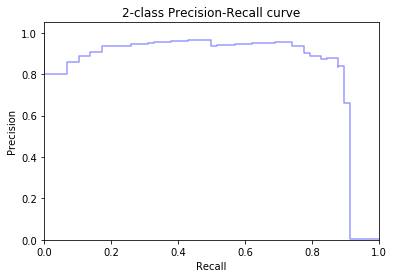

In [55]:
thresholds = np.append(thresholds, 1)
f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

Threshold cutoff:  0.8635978698730469
Max F1-score at cut-off :  0.8793103448275863


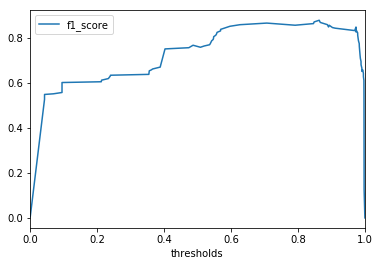

In [56]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())

thresh = scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0]

scrs.plot(x='thresholds', y='f1_score')

In [58]:
scrs.loc[scrs['f1_score'] == scrs.f1_score.max()]

,precision,recal,thresholds,f1_score
112,0.87931,0.87931,0.863598,0.87931


In [60]:
frame = scrs.loc[scrs['precision'] == scrs['recal']]

In [66]:
scrs.loc[scrs['f1_score'] == 0.759124087591241]

,precision,recal,thresholds,f1_score
93,0.658228,0.896552,0.508834,0.759124


In [63]:
thresh = frame['thresholds'].values[0]

In [64]:
thresh

0.8635978698730469

In [65]:
pred = [1 if y>=thresh else 0 for y in p_sl[:, 1]]

f1_score(y_test, pred)

0.8793103448275863

In [67]:
test_data_probs = sl.predict_proba(test_data)
test_data_pred = [1 if y>=thresh else 0 for y in test_data_probs[:, 1]]

submission = pd.DataFrame({'TransactionId' : testTransId, 'FraudResult' : test_data_pred})
submission.to_csv('submission.csv', index=False)

In [185]:
test_data_predictions = voting.predict(test_data)

submission = pd.DataFrame({'TransactionId' : testTransId, 'FraudResult' : test_data_predictions})
submission.to_csv('sub.csv', index=False)

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
